In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")

print("Path to dataset files:", path)

100%|██████████| 9.76G/9.76G [07:20<00:00, 23.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alessandrasala79/ai-vs-human-generated-dataset/versions/4


In [3]:
import pandas as pd
import os

# Define dataset path
dataset_path = "/root/.cache/kagglehub/datasets/alessandrasala79/ai-vs-human-generated-dataset/versions/4"

# Load CSV
train_df = pd.read_csv(os.path.join(dataset_path, "train.csv"))

# Remove unnecessary columns if present
train_df.drop(columns=["Unnamed: 0"], errors="ignore", inplace=True)

# Append full file paths
train_df["file_name"] = train_df["file_name"].apply(lambda x: os.path.join(dataset_path, x))

# Display dataset info
print("Dataset Info:")
print(train_df.info())
print("\nSample Data:")
display(train_df.head())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79950 entries, 0 to 79949
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  79950 non-null  object
 1   label      79950 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ MB
None

Sample Data:


,file_name,label
0,/root/.cache/kagglehub/datasets/alessandrasala...,1
1,/root/.cache/kagglehub/datasets/alessandrasala...,0
2,/root/.cache/kagglehub/datasets/alessandrasala...,1
3,/root/.cache/kagglehub/datasets/alessandrasala...,0
4,/root/.cache/kagglehub/datasets/alessandrasala...,1


In [4]:
# Find missing images
missing_files = train_df[~train_df["file_name"].apply(os.path.exists)]
print(f"Missing images: {len(missing_files)}")

# If any missing images exist, display a few
if not missing_files.empty:
    print("\nMissing Files Sample:")
    display(missing_files.head())


Missing images: 0


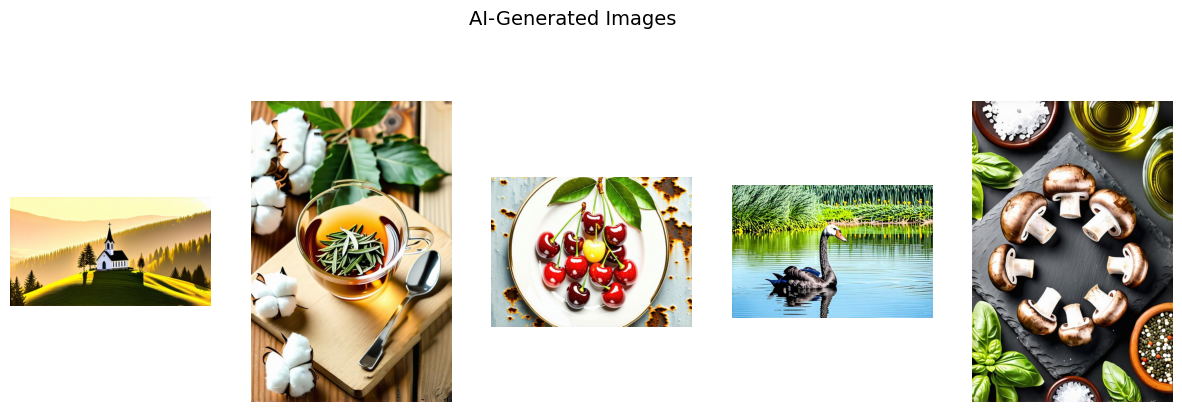

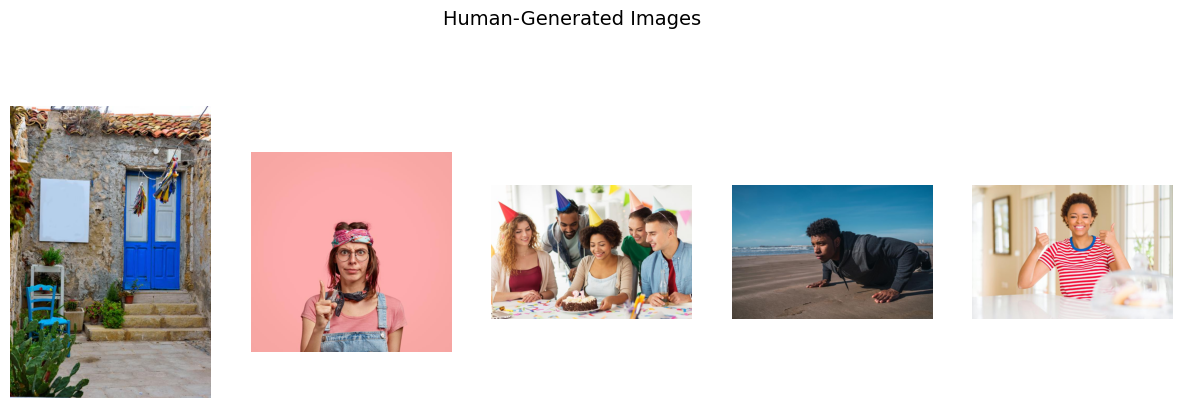

In [5]:
import random
import matplotlib.pyplot as plt
from PIL import Image

# Separate AI and Human-generated images
ai_images = train_df[train_df["label"] == 1]["file_name"].tolist()
human_images = train_df[train_df["label"] == 0]["file_name"].tolist()

# Function to display sample images
def display_images(image_paths, title, num_samples=5):
    plt.figure(figsize=(15, 5))

    for i, img_path in enumerate(random.sample(image_paths, num_samples)):
        try:
            img = Image.open(img_path)
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img)
            plt.axis("off")
        except Exception as e:
            print(f"Error loading {img_path}: {e}")

    plt.suptitle(title, fontsize=14)
    plt.show()

# Display AI-generated images
display_images(ai_images, "AI-Generated Images")

# Display Human-generated images
display_images(human_images, "Human-Generated Images")


In [6]:
from PIL import Image
import numpy as np

def analyze_image_sizes(df, num_samples=500):
    sizes = []

    for img_path in df["file_name"].sample(num_samples, random_state=42):
        try:
            img = Image.open(img_path)
            sizes.append(img.size)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

    sizes = np.array(sizes)

    print("Unique Image Sizes:", np.unique(sizes, axis=0))

# Analyze image sizes
analyze_image_sizes(train_df)


Unique Image Sizes: [[480 768]
 [496 768]
 [512 768]
 [528 768]
 [544 768]
 [560 768]
 [576 768]
 [592 768]
 [608 768]
 [624 768]
 [688 768]
 [704 768]
 [720 768]
 [752 768]
 [768 144]
 [768 240]
 [768 304]
 [768 336]
 [768 352]
 [768 368]
 [768 384]
 [768 400]
 [768 416]
 [768 432]
 [768 448]
 [768 464]
 [768 480]
 [768 496]
 [768 512]
 [768 528]
 [768 544]
 [768 560]
 [768 576]
 [768 592]
 [768 608]
 [768 624]
 [768 640]
 [768 656]
 [768 672]
 [768 688]
 [768 704]
 [768 720]
 [768 736]
 [768 752]
 [768 768]]


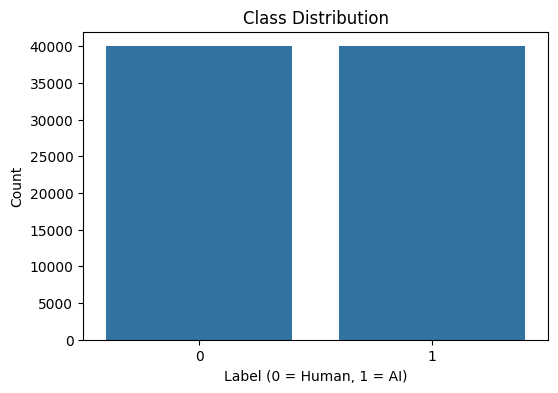

In [7]:
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x=train_df["label"])
plt.xlabel("Label (0 = Human, 1 = AI)")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()


In [8]:
train_df['label'] = train_df['label'].astype(str)

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image Parameters
IMG_SIZE = (299, 299)  # InceptionV3 default input size
BATCH_SIZE = 32

# Define data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split into train & validation
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Only rescale test images

# Create train and validation generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="file_name",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",  # AI (1) vs Human (0)
    subset="training"
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="file_name",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation"
)


Found 63960 validated image filenames belonging to 2 classes.
Found 15990 validated image filenames belonging to 2 classes.


In [10]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load pre-trained InceptionV3 model (excluding top layers)
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(299, 299, 3))

# Freeze Pre-Trained Layers (Keep existing weights)
for layer in base_model.layers:
    layer.trainable = False

# Add Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)  # Dropout to prevent overfitting
x = Dense(1, activation="sigmoid")(x)  # Binary classification

# Create Model
model = Model(inputs=base_model.input, outputs=x)

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Model Summary
model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 22,852,385 (87.17 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [11]:
EPOCHS = 3 # You can increase this if needed

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 1909s 945ms/step - accuracy: 0.7496 - loss: 0.4986 - val_accuracy: 0.8490 - val_loss: 0.3490
Epoch 2/3
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 1836s 919ms/step - accuracy: 0.8515 - loss: 0.3412 - val_accuracy: 0.8718 - val_loss: 0.3036
Epoch 3/3
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 1781s 891ms/step - accuracy: 0.8659 - loss: 0.3123 - val_accuracy: 0.8764 - val_loss: 0.2900


In [12]:
# Prepare test data generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=train_df,  # Update with actual test set if available
    x_col="file_name",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

# Evaluate model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Found 79950 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2499/2499 ━━━━━━━━━━━━━━━━━━━━ 405s 162ms/step - accuracy: 0.8769 - loss: 0.2892
Test Accuracy: 87.83%


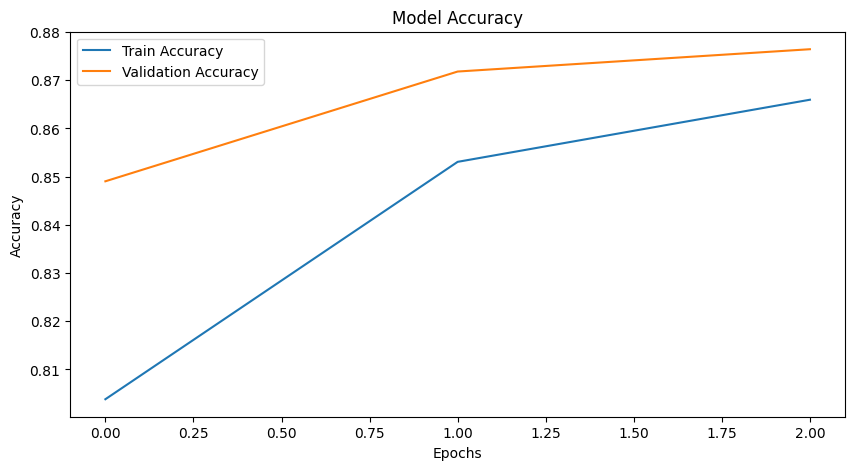

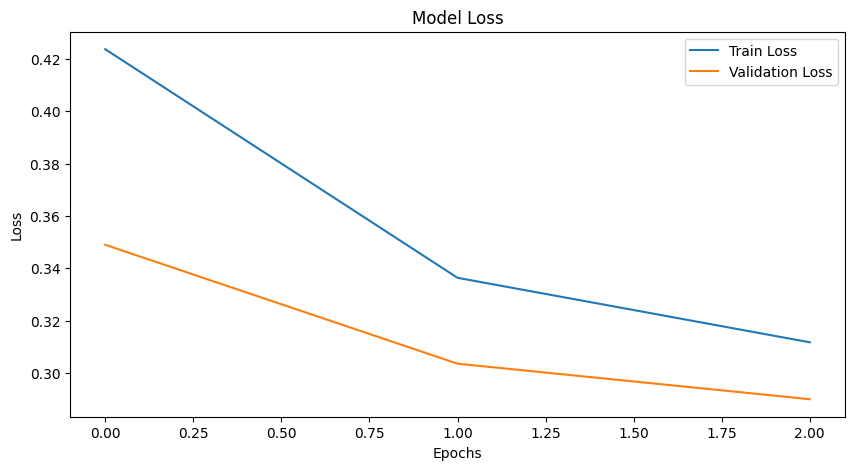

In [13]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")
plt.show()
